# Logistic Regression on MNIST

In [5]:
!jupyter kernelspec list


Available kernels:
  mojo-max-jupyter-kernel    /Users/nithin/Library/Jupyter/kernels/mojo-max-jupyter-kernel
  python3                    /opt/anaconda3/share/jupyter/kernels/python3


## Importing libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import struct
from array import array
import random
from copy import deepcopy

## Obtaining the MNIST data

In [10]:
input_path = ''
training_images_filepath = join(input_path, 'MNIST/train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'MNIST/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 'MNIST/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 'MNIST/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [11]:

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img/255
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self,load_train=True,augment=False,replace_set=True, num_of_copies=1):
        if load_train:
            x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        else: x_train,y_train = ([],[])
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        if augment:
            if load_train:
                x_train, y_train = augment_data(x_train,y_train,replace_set,num_of_copies)
            x_test, y_test = augment_data(x_test, y_test, replace_set=True, num_of_copies=1)
        return (x_train, y_train),(x_test, y_test)


def image_shift(image,shift=None,shift_x = True,shift_y = True):
    image = np.asarray(image)
    if shift is None:
        if shift_x:
            x_shift = random.randint(-3,3)
        else:
            x_shift = 0
        if shift_y:
            y_shift = random.randint(-3,3)
        else:
            y_shift = 0
    else: x_shift,y_shift = shift
    if x_shift >= 0:
        # Remove columns from the left and pad with zeros on the right
        image = image[:, x_shift:]  # Remove columns from the left
        image = np.hstack((image, np.zeros((image.shape[0], x_shift))))  # Pad with zeros on the right
    else:
        # Remove columns from the right and pad with zeros on the left
        image = image[:, :image.shape[1] + x_shift]  # Remove columns from the right
        image = np.hstack((np.zeros((image.shape[0], abs(x_shift))), image))  # Pad with zeros on the left

    if y_shift >= 0:
        # Remove rows from the top and pad with zeros at the bottom
        image = image[y_shift:, :]  # Remove rows from the top
        image = np.vstack((image, np.zeros((y_shift, image.shape[1]))))  # Pad with zeros at the bottom
    else:
        # Remove rows from the bottom and pad with zeros at the top
        image = image[:image.shape[0] + y_shift, :]  # Remove rows from the bottom
        image = np.vstack((np.zeros((abs(y_shift), image.shape[1])), image))
    return image

def apply_noise(image,num_of_points=None):
    if num_of_points is None:
        num_of_points = random.randint(5,20)
    image = deepcopy(image)
    for _ in range(num_of_points):
        x,y = np.random.randint(0,28,2)
        noise = np.random.uniform(0,1)
        image[x][y] = np.clip(image[x][y]+noise,0.0,1.0)
    return image


def augment_data(x, y, replace_set=False, num_of_copies=9):
    if replace_set:
        x_new = []
        y_new = []
    else:
        x_new = deepcopy(x)
        y_new = deepcopy(y)
    for i,image in enumerate(x):
        for _ in range(num_of_copies):
            shifted_image = image_shift(image)
            # shifted_image = apply_noise(shifted_image)
            x_new.append(shifted_image)
            y_new.append(y[i])
    return x_new,y_new


mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

## Modifying the data for logistic regression

In [14]:
x_train = np.asarray(x_train).reshape(-1,784)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test).reshape(-1,784)
y_test = np.asarray(y_test)

In [15]:
y_train_oh = np.zeros((len(y_train),10))
for i in range(len(y_train)):
    index = y_train[i]
    y_train_oh[i,index] = 1
y_train = y_train_oh

y_test_oh = np.zeros((len(y_test),10))
for i in range(len(y_test)):
    index = y_test[i]
    y_test_oh[i,index] = 1

y_test = y_test_oh

## Defining the model

### Notations

$$\large n_c \rightarrow \text{No. of classes}$$

$$\large n_f \rightarrow \text{No. of features}$$

$$\large W_{n_c \times n_f} \rightarrow \text{Weight matrix}$$

$$\large b_{n_c \times 1} \rightarrow \text{Bias vector}$$

$$\large \hat y \rightarrow \text{Model output}$$

### Forward pass

A logistic regression model is used for classifcation purposes where one would define $n_c$ linear regression models, each with their own weight vector and bias value. The outputs of these linear regression models are then plugged into a softmax function to obtain a vector of length $n_c$ where the one with the highest value will be the predicted class. The value can also act as the confidence of the model.

$$\large \text{softmax}(\vec{x}) = \frac{e^{\vec{x}}}{\sum_i e^{x_i}}$$

Thus, the forward pass becomes :

$$\large z = W \cdot X + b$$

$$\large \hat y = \text{softmax}(z)$$

and the predicted class  is

$$\large \text{y\_pred} = \underset{j}{\arg\max}\text{ } \hat y $$

### Backward pass

Calculating $\Large \frac{\partial \mathcal L}{\partial z}$

$$\large
\frac{\partial \mathcal L}{\partial z} = \frac{\partial \mathcal L}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial z}
$$

$$\large
\text{Assuming }\mathcal L = -\displaystyle\sum_j y_j ln(\hat y_j)
$$

$$\large \frac{\partial \mathcal L}{\partial z_i} = -\frac{\partial}{\partial z_i} \sum_j y_j \cdot \ln\hat{y}_j$$

$$\large \frac{\partial \mathcal L}{\partial z_i} = -\sum_j y_j \cdot \frac{1}{\hat{y}_j}\frac{\partial \hat{y}_j}{\partial z_i}$$

Let's calculate $\LARGE \frac{\partial \hat{y}_j}{\partial z_i}$.

For $\large i = j$:

$$\large
\frac{\partial \hat{y}_i}{\partial z_i} = \frac{\partial}{\partial z_i} \frac{e^{z_i}}{\sum_j e^{z_i}}
$$

$$\large
\frac{\partial \hat{y}_i}{\partial z_i} = \frac{ \sum_j e^{z_i} \times e^{z_i} - e^{z_i} \times e^{z_i}}{\left(\sum_j e^{z_i}\right)^2} = \frac{e^{z_i}}{ \sum_j e^{z_i}} \times \frac{\sum_j e^{z_i} - e^{z_i}}{\sum_j e^{z_i}}
$$

<div style="text-align: center;">
  <div style="border: 2px dashed white; padding: 5px; display: inline-block;">
    \( \LARGE \frac{\partial \hat{y}_i}{\partial z_i} = \hat{y}_i (1 - \hat{y}_i) \)
  </div>
</div>


For $\large i \neq j$:

$$\large
\frac{\partial \hat{y}_j}{\partial z_i} = \frac{\partial}{\partial z_i} \frac{e^{z_j}}{\sum_k e^{z_k}}
$$

$$\large
\frac{\partial \hat{y}_j}{\partial z_i} = -\frac{e^{z_j} \times e^{z_i}}{\left(\sum_k e^{z_k}\right)^2}
$$

<div style="text-align: center;">
  <div style="border: 2px dashed white; padding: 5px; display: inline-block;">
    \( \LARGE \frac{\partial \hat{y}_j}{\partial z_i} = -\hat{y}_j\hat{y}_i \)
  </div>
</div>


Substituting the result, we get

$$\large
\frac{\partial \mathcal L}{\partial z_i} =  \hat{y}_i{\displaystyle \sum_{i \neq j} y_j} - y_i (1-\hat{y}_i)
$$

Which simplifies to

$$\large
\frac{\partial \mathcal L}{\partial z_i} = - y_i +  \hat{y}_i {\displaystyle \sum_j y_j} 
$$

For one-hot encoded labels, $$\large {\displaystyle \sum_j y_j} = 1$$

Which gives
$$\large \frac{\partial \mathcal L}{\partial z_i} =\hat{y}_i - y_i$$

$$\large \therefore \boxed{\frac{\partial \mathcal L}{\partial z} = \hat{y} - y}$$

In [37]:
class Logistic:
    def __init__(self, num_classes, num_feats):
        self.n_c = num_classes
        self.n_f = num_feats

        self.W = np.random.randn(self.n_c, self.n_f)
        self.B = np.zeros((self.n_c, 1))

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def cross_entropy(self, y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))
    
    def forward(self, X):
        return self.softmax(np.dot(X,self.W.T) + self.B.T)

    def backward(self, X, y_true, y_pred, learning_rate=0.001):
        dW = (1 / len(x_train)) * np.dot((y_pred - y_train).T, x_train)
        db = (1 / len(x_train)) * np.sum(y_pred - y_train, axis=0, keepdims=True).T  
    
        self.W -= learning_rate * dW
        self.B -= learning_rate * db
        return self.cross_entropy(y_true, y_pred)

In [49]:
accuracies = []
losses = []

In [51]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))

num_classes = 10
num_feats = x_train.shape[1]

logistic = Logistic(num_classes, num_feats)

epochs = 400
learning_rate = 0.9

for epoch in range(epochs):

    y_pred = logistic.forward(x_train)
    loss = logistic.backward(x_train, y_train, y_pred, learning_rate)
    losses.append(loss)

    y_pred = logistic.forward(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    accuracy = 100 * np.mean(y_pred == y_true)
    accuracies.append(accuracy)
    # Print loss every 500 epochs
    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}, Accuracy : {accuracy:.2f}%")
    

Epoch 25/400, Loss: 2.351679, Accuracy : 60.40%
Epoch 50/400, Loss: 1.516538, Accuracy : 71.77%
Epoch 75/400, Loss: 1.218971, Accuracy : 76.94%
Epoch 100/400, Loss: 1.059182, Accuracy : 79.60%
Epoch 125/400, Loss: 0.955990, Accuracy : 81.17%
Epoch 150/400, Loss: 0.882315, Accuracy : 82.20%
Epoch 175/400, Loss: 0.826294, Accuracy : 82.98%
Epoch 200/400, Loss: 0.781717, Accuracy : 83.67%
Epoch 225/400, Loss: 0.745049, Accuracy : 84.34%
Epoch 250/400, Loss: 0.714151, Accuracy : 84.86%
Epoch 275/400, Loss: 0.687639, Accuracy : 85.34%
Epoch 300/400, Loss: 0.664559, Accuracy : 85.70%
Epoch 325/400, Loss: 0.644232, Accuracy : 86.01%
Epoch 350/400, Loss: 0.626154, Accuracy : 86.28%
Epoch 375/400, Loss: 0.609945, Accuracy : 86.53%
Epoch 400/400, Loss: 0.595310, Accuracy : 86.71%


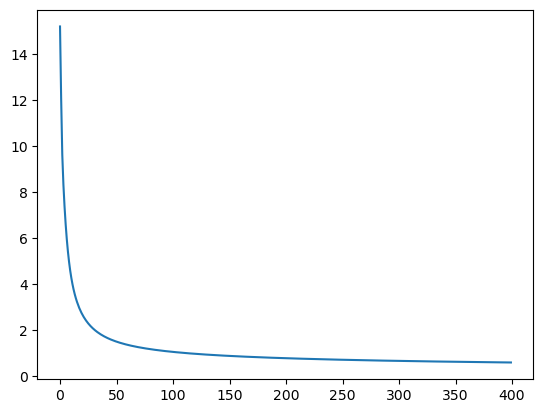

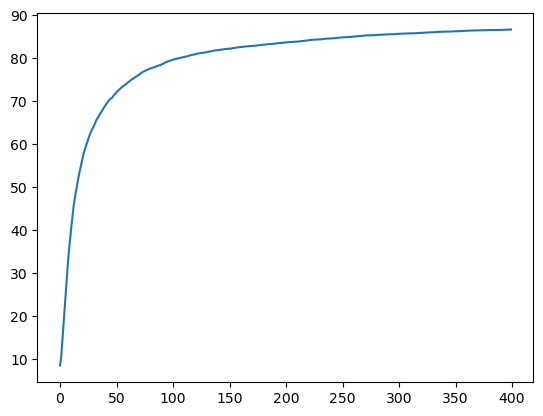

In [53]:
plt.plot(losses)
plt.show()
plt.plot(accuracies)
plt.show()

In [59]:
np.save('logistic_reg_weights_mnist.npy',logistic.W)

In [61]:
np.save('logistic_reg_bias_mnist.npy',logistic.B)